# Synthesize Multiple Tables (HMA)

In this notebook, we'll the SDV library to create synthetic data for multiple, connected tables and evaluate it. The SDV uses machine learning to learn patterns from real data and emulates them when creating synthetic data.

We'll use the **HMA** algorithm to do this. HMA is a customizable and transparent way to synthesize multi-table data.

_Last Edit: Dec 12, 2023_

# 0. Installation

Install the SDV library.

In [ ]:
%pip install sdv

**Important**: If you're using Google Colab, please restart the runtime by clicking `Runtime` in the top menu bar and then `Restart Session`

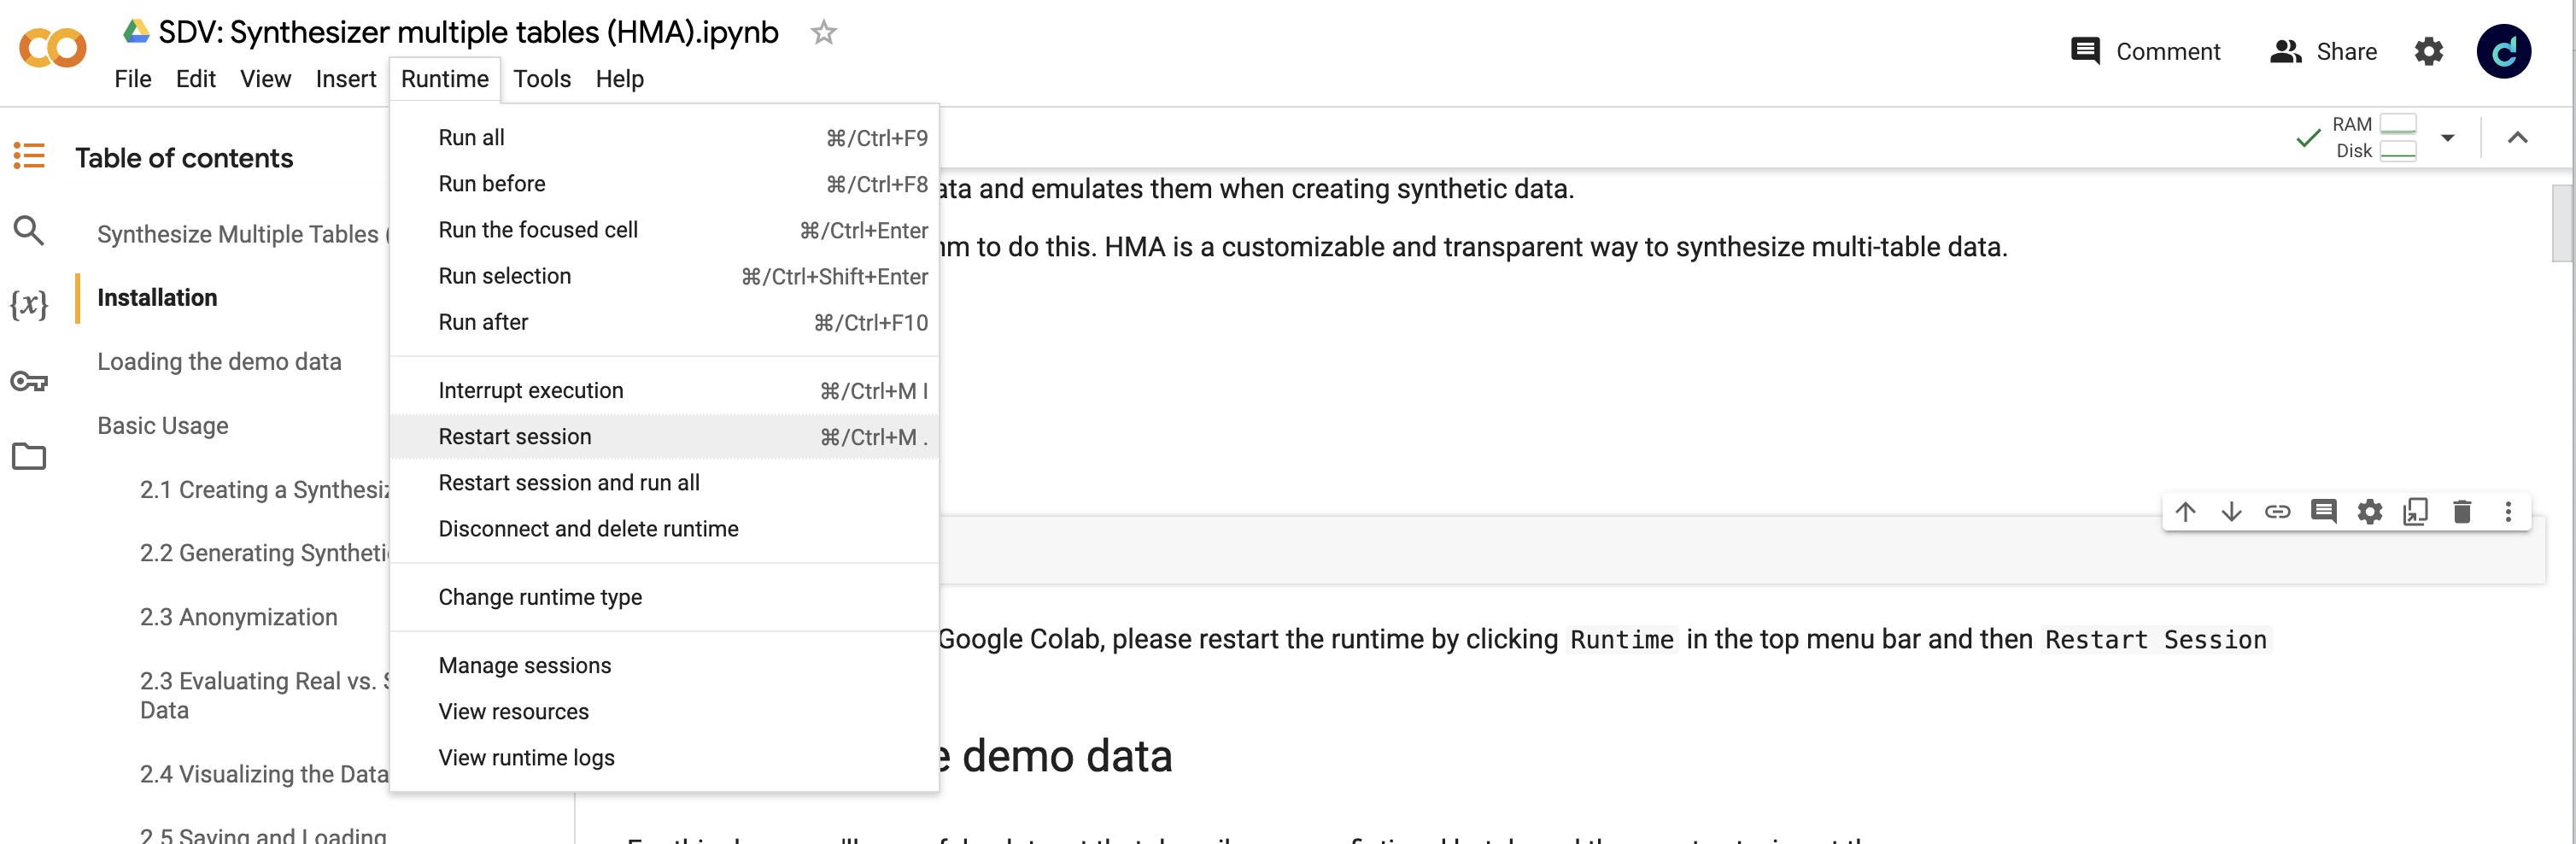

# 1. Loading the demo data
For this demo, we'll use a fake dataset that describes some fictional hotels and the guests staying at them.

In [ ]:
from sdv.datasets.demo import download_demo

real_data, metadata = download_demo(
    modality='multi_table',
    dataset_name='fake_hotels'
)

**Details**: The dataset is available in two tables.

- The `hotels` table describes some stats about each hotel. The column `hotel_id` is a _primary key_ that uniquely identifies every hotel.
- The `guests` table describes the guests that are staying at each hotel. The column `hotel_id` in this table is a _foreign key_ that refers to the `hotels` table.

In [ ]:
real_data['hotels'].head(3)

,hotel_id,city,state,rating,classification
0,HID_000,Boston,Massachusetts,4.8,RESORT
1,HID_001,Boston,Massachuesetts,4.1,CHAIN
2,HID_002,San Francisco,California,3.8,MOTEL


In [ ]:
real_data['guests'].head(3)

,guest_email,hotel_id,has_rewards,room_type,amenities_fee,checkin_date,checkout_date,room_rate,billing_address,credit_card_number
0,awolf@phillips.com,HID_000,False,BASIC,37.89,27 Dec 2020,28 Dec 2020,156.23,"993 Rebecca Landing\nJesseburgh, PA 05072",4075084747483975747
1,tonya44@wilkinson-wilkins.com,HID_000,False,BASIC,24.37,30 Dec 2020,31 Dec 2020,139.43,"958 Beverly Bypass\nSouth Ronald, GA 46368",180072822063468
2,harriskathleen@goodwin.com,HID_000,True,DELUXE,0.00,17 Sep 2020,19 Sep 2020,403.33,"8302 Nathaniel Pike\nRileyland, TX 71613",38983476971380


The demo also includes **metadata**, a description of the dataset. It includes the keys, the connections between the tables as well as the data types for each column (called "sdtypes").

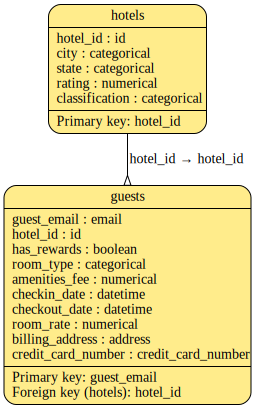

In [ ]:
metadata.visualize(show_table_details='full')

# 2. Basic Usage

## 2.1 Creating a Synthesizer

An SDV **synthesizer** is an object that you can use to create synthetic data. It learns patterns from the real data and replicates them to generate synthetic data.

In [ ]:
from sdv.multi_table import HMASynthesizer

synthesizer = HMASynthesizer(metadata)
synthesizer.fit(real_data)

Preprocess Tables: 100%|██████████| 2/2 [00:01<00:00,  1.20it/s]



Learning relationships:


(1/1) Tables 'hotels' and 'guests' ('hotel_id'): 100%|██████████| 10/10 [00:09<00:00,  1.07it/s]


Modeling Tables: 100%|██████████| 2/2 [00:05<00:00,  2.53s/it]


Now the synthesizer is ready to use!

## 2.2 Generating Synthetic Data

Use the `sample` function. We can pass in a value to `scale` the size of the original dataset. For example, passing in `scale=2` create twice as many hotels and guests as the original data contained.

In [ ]:
synthetic_data = synthesizer.sample(scale=2)

The result is a dictionary with keys `'hotels'` and `'guests'` that map to the synthetic data for each table.

In [ ]:
synthetic_data['hotels'].head(3)

,hotel_id,city,state,rating,classification
0,HID_018,Boston,California,3.8,CHAIN
1,HID_011,San Francisco,California,4.5,RESORT
2,HID_001,San Francisco,Massachusetts,4.5,MOTEL


In [ ]:
synthetic_data['guests'].head(3)

,guest_email,hotel_id,has_rewards,room_type,amenities_fee,checkin_date,checkout_date,room_rate,billing_address,credit_card_number
0,moodyeric@example.net,HID_018,False,BASIC,29.93,14 Sep 2020,23 Sep 2020,82.66,"PSC 4273, Box 0888\nAPO AA 28423",5161033759518983
1,coryguzman@example.com,HID_018,False,BASIC,3.90,21 Apr 2020,11 May 2020,104.87,"417 Lawrence Hollow\nEast Ericshire, IN 65660",4133047413145475690
2,caitlinlee@example.net,HID_018,False,BASIC,4.52,23 Sep 2020,10 Oct 2020,124.86,"69754 Mcguire Haven Apt. 260\nCrawfordside, IN...",4977328103788


The synthesizer is generating synthetic guests in the **same format as the original data**. It is also generating **connections between the tables** that make sense.

## 2.3 Evaluating Real vs. Synthetic Data
SDV has built-in functions for evaluating the synthetic data and getting more insight.

As a first step, we can run a **diagnostic** to ensure that the data is valid. SDV's diagnostic performs some basic checks such as:

- All primary keys must be unique
- Continuous values must adhere to the min/max of the real data
- Discrete columns (non-PII) must have the same categories as the real data
- Etc.

In [ ]:
from sdv.evaluation.multi_table import run_diagnostic

diagnostic = run_diagnostic(
    real_data=real_data,
    synthetic_data=synthetic_data,
    metadata=metadata
)

Generating report ...

(1/3) Evaluating Data Validity: |██████████| 15/15 [00:00<00:00, 587.25it/s]|
Data Validity Score: 100.0%

(2/3) Evaluating Data Structure: |██████████| 2/2 [00:00<00:00, 119.08it/s]|
Data Structure Score: 100.0%

(3/3) Evaluating Relationship Validity: |██████████| 1/1 [00:00<00:00, 66.08it/s]|
Relationship Validity Score: 100.0%

Overall Score (Average): 100.0%



<font color="green"><b>The score is 100%</b></font>, indicating that the data is fully valid.

We can also measure the **data quality** or the statistical similarity between the real and synthetic data. This value may vary anywhere from 0 to 100%.

In [ ]:
from sdv.evaluation.multi_table import evaluate_quality

quality_report = evaluate_quality(
    real_data,
    synthetic_data,
    metadata
)

Generating report ...

(1/4) Evaluating Column Shapes: |██████████| 15/15 [00:00<00:00, 598.92it/s]|
Column Shapes Score: 85.61%

(2/4) Evaluating Column Pair Trends: |██████████| 55/55 [00:00<00:00, 118.06it/s]|
Column Pair Trends Score: 71.97%

(3/4) Evaluating Cardinality: |██████████| 1/1 [00:00<00:00, 55.58it/s]|
Cardinality Score: 70.0%

(4/4) Evaluating Intertable Trends: |██████████| 50/50 [00:00<00:00, 90.90it/s]| 
Intertable Trends Score: 68.49%

Overall Score (Average): 74.02%



According to the score, the synthetic data is about 70% similar to the real data in terms of statistical similarity.

We can also get more details from the report. For example, the Column Shapes sub-score is 83%. Which columns had the highest vs. the lowest scores?

In [ ]:
quality_report.get_details('Column Shapes')

,Table,Column,Metric,Score
0,guests,has_rewards,TVComplement,0.966565
1,guests,room_type,TVComplement,0.974924
2,guests,amenities_fee,KSComplement,0.620339
3,guests,checkin_date,KSComplement,0.880699
4,guests,checkout_date,KSComplement,0.943109
5,guests,room_rate,KSComplement,0.886778
6,hotels,city,TVComplement,0.750000
7,hotels,state,TVComplement,0.850000
8,hotels,rating,KSComplement,0.738562
9,hotels,classification,TVComplement,0.950000


## 2.4 Visualizing the Data
For more insights, we can visualize the real vs. synthetic data.

Let's perform a 1D visualization comparing a column of the real data to the synthetic data.

In [ ]:
from sdv.evaluation.multi_table import get_column_plot

fig = get_column_plot(
    real_data=real_data,
    synthetic_data=synthetic_data,
    column_name='has_rewards',
    table_name='guests',
    metadata=metadata
)

fig.show()

We can also visualize in 2D, comparing the correlations of a pair of columns.

In [ ]:
from sdv.evaluation.multi_table import get_column_pair_plot

fig = get_column_pair_plot(
    real_data=real_data,
    synthetic_data=synthetic_data,
    column_names=['room_rate', 'room_type'],
    table_name='guests',
    metadata=metadata
)

fig.show()

## 2.3 Anonymization

In the original dataset, we had some sensitive columns such as the guest's email, billing address and phone number. In the synthetic data, these columns are **fully anonymized** -- they contain entirely fake values that follow the format of the original.

PII columns are not included in the quality report, but we can inspect them to see that they are different.

In [ ]:
sensitive_columns = ['guest_email', 'billing_address', 'credit_card_number']
real_data['guests'][sensitive_columns].head()

,guest_email,billing_address,credit_card_number
0,awolf@phillips.com,"993 Rebecca Landing\nJesseburgh, PA 05072",4075084747483975747
1,tonya44@wilkinson-wilkins.com,"958 Beverly Bypass\nSouth Ronald, GA 46368",180072822063468
2,harriskathleen@goodwin.com,"8302 Nathaniel Pike\nRileyland, TX 71613",38983476971380
3,kayladiaz@wallace-simmons.com,"77 Massachusetts Ave\nCambridge, MA 02139",4969551998845740
4,paigemendoza@tran-martin.com,"1234 Corporate Drive\nBoston, MA 02116",3558512986488983


In [ ]:
synthetic_data['guests'][sensitive_columns].head()

,guest_email,billing_address,credit_card_number
0,moodyeric@example.net,"PSC 4273, Box 0888\nAPO AA 28423",5161033759518983
1,coryguzman@example.com,"417 Lawrence Hollow\nEast Ericshire, IN 65660",4133047413145475690
2,caitlinlee@example.net,"69754 Mcguire Haven Apt. 260\nCrawfordside, IN...",4977328103788
3,andreasmith@example.net,"959 Copeland Drive\nLake Kellyport, PA 61063",3524946844839485
4,fostermichael@example.com,"496 Lynn Isle Suite 560\nTeresaport, OK 89054",4446905799576890978


## 2.5 Saving and Loading
We can save the synthesizer to share with others and sample more synthetic data in the future.

In [ ]:
synthesizer.save('my_synthesizer.pkl')

synthesizer = HMASynthesizer.load('my_synthesizer.pkl')

# 3. HMA Customization

A key benefit of using the HMA is **customization and transparency**. This synthesizer uses classical statistics to estimate the shape of every column using a 1D distribution. We can set these shapes ourselves.

In [ ]:
custom_synthesizer = HMASynthesizer(
    metadata,
    verbose=False
)

custom_synthesizer.set_table_parameters(
    table_name='hotels',
    table_parameters={
        'default_distribution': 'truncnorm'
    }
)

custom_synthesizer.fit(real_data)

After training, we can inspect the distributions. In this case, the synthesizer returns the parameter it learned using the truncnorm distribution.

<font color=navy><i>More information about truncnorm distribution is available in the [scipy documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.truncnorm.html).</i></font>

In [ ]:
learned_distributions = custom_synthesizer.get_learned_distributions(table_name='hotels')
learned_distributions['rating']

{'distribution': 'truncnorm',
 'learned_parameters': {'a': -0.4166664183140626,
  'b': 0.4166667494508458,
  'loc': 4.299999761581422,
  'scale': 1.4400005722046472}}

By setting these distributions strategically, you can make tradeoffs in the quality of your synthetic data.

# 5. What's Next?

For more information about the HMA Synthesizer, visit the **[documentation](https://docs.sdv.dev/sdv/multi-table-data/modeling/hmasynthesizer)**.

**Need more help?** [Browse all tutorials](https://docs.sdv.dev/sdv/demos).

---

# About

The [Synthetic Data Vault Project](https://github.com/sdv-dev/SDV) was first created at MIT's Data to AI Lab in 2016. After 4 years of research and traction with enterprise, we created [DataCebo](https://datacebo.com/) in 2020 with the goal of growing the project. Today, DataCebo is the proud developer of SDV, the largest ecosystem for tabular synthetic data generation & evaluation.

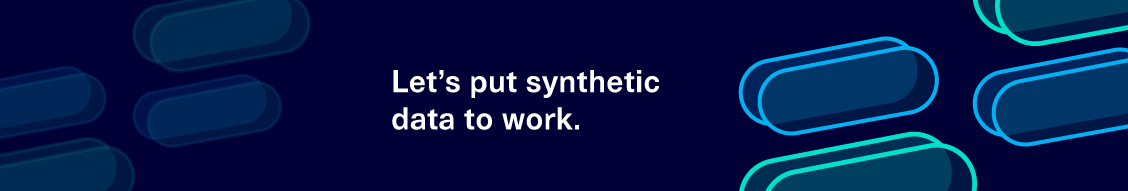